# Milestone 3 

## Library installations and imports

In [ ]:
! pip install TextBlob
! pip install plotly
! pip install nltk
! pip install vaderSentiment
! pip install scikit-learn
! pip install torch torchvision

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns
import os

import re
from textblob import TextBlob
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from datetime import datetime, date, time
from dateutil.parser import parse

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings

In [ ]:
nltk.download('punkt')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [4]:
warnings.filterwarnings('ignore')

In [5]:
# Setting up a color blind friendly pallete

CB_color_cycle = ['#377eb8','#ff7f00','#4daf4a',
                  '#f781bf','#a65628','#984ea3',
                  '#999999','#e41a1c','#dede00']

In [6]:
pd.set_option('display.max_rows', 40)

## Loading data

In [7]:
# Importing the data
movies = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep = '\t', header = None)
characters = pd.read_csv('MovieSummaries/character.metadata.tsv', sep = '\t', header = None)

# Importing txt files
name_clusters = pd.read_csv('MovieSummaries/name.clusters.txt', sep = '\t', header = None)
summaries_off = pd.read_csv('MovieSummaries/plot_summaries.txt', sep = '\t', header = None)
tv_tropes = pd.read_csv('MovieSummaries/tvtropes.clusters.txt', sep = '\t', header = None)

# Loading the NRC lexicon emotion intensity data
data_NRC = pd.read_table("NRC-lexicon/NRC-Emotion-Intensity-Lexicon-v1-ForVariousLanguages-withZeroIntensityEntries.txt")


In [8]:
movies.columns = ['Wikipedia Movie ID', 'Freebase Movie ID', 'Movie Name', 'Movie Release Date', 'Movie Box Office Revenue', 'Movie Runtime', 'Movie Languages', 'Movie Countries', 'Movie Genres']
name_clusters.columns = ['Name', 'Freebase Movie ID']
summaries_off.columns = ['Wikipedia Movie ID', 'Plot Summary']
characters.columns = ['Wikipedia Movie ID', 'Freebase Movie ID', 'Movie Release Date', 'Character Name', 'Actor DOB', 'Actor gender', 'Actor height', 'Actor ethinicity', 'Actor Name', 'Actor Age', 'Freebase Character Map', 'Unknown ID1', 'Unknown ID1']

data_filt = data_NRC.iloc[:,0:9].copy()

In [9]:
display(movies)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


## Cleaning the data

In [10]:
def extract_language(language_data):
    language_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, language_data)
    for match in matches:
        language_names.append(match[1].split(' ')[0])  # Extract the language name
    return ','.join(language_names)

def extract_countries(country_data):
    country_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, country_data)
    for match in matches:
        country_names.append(match[1])  # Extract the country name
    return ','.join(country_names)


def extract_genres(genre_data):
    genre_names = []
    pattern = r'"([^"]+)"\s*:\s*"([^"]+)"'
    matches = re.findall(pattern, genre_data)
    for match in matches:
        genre_names.append(match[1])  # Extract the genre name
    return ','.join(genre_names)

def extract_first_genre(genre_list):
    if genre_list:
        return genre_list[0]
    else:
        return None 

# Function to extract the release year from the date
def extract_release_year(date_str):
    try:
        # Attempt to extract the year from the 'YYYY-MM-DD' format
        return pd.to_datetime(date_str).year
    except (ValueError, TypeError):
        try:
            # Attempt to extract the year from 'YYYY' format
            return int(date_str)
        except ValueError:
            return None  # Return None for invalid or missing dates
        
def contains_nan(lst):
    return any(pd.isna(item) for item in lst)

def is_single_nan(lst):
    return len(lst) == 1 and pd.isna(lst[0])

In [11]:
movies["Movie Languages"] = movies["Movie Languages"].apply(extract_language) # extract languages
movies["Movie Countries"] = movies["Movie Countries"].apply(extract_countries) # extract countries
movies["Movie Genres"] = movies["Movie Genres"].apply(extract_genres) # extract genres
# movies['Movie Release Date'] = pd.to_datetime(movies['Movie Release Date'], errors='coerce') # convert the release date into datetime format
movies['Movie Release Year'] = movies['Movie Release Date'].apply(extract_release_year) # extract only the year

In [12]:
movies['Movie Genres'] = movies['Movie Genres'].apply(lambda x: x.split(','))
movies['Movie Countries'] = movies['Movie Countries'].apply(lambda x: x.split(','))
movies['Movie Languages'] = movies['Movie Languages'].apply(lambda x: x.split(','))

movies['Main Genre'] = movies['Movie Genres'].apply(extract_first_genre) #extract first genre as main genre

In [13]:
# Identify all duplicates (including the first occurrence)
duplicates = movies[movies.duplicated(subset='Movie Name', keep=False)].sort_values(by='Movie Name').copy()

display(duplicates)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre
77290,8422241,/m/0272wbj,100 Days,1991,NaN,161.0,[Hindi],[India],"[Horror, Suspense, World cinema]",1991.0,Horror
18992,15498803,/m/03mc7x8,100 Days,2001-02-01,NaN,100.0,[English],[United Kingdom],[Drama],2001.0,Drama
12205,31239628,/m/0gj9wpb,100% Love,2011-04,NaN,140.0,[Telugu],[],[Romantic comedy],2011.0,Romantic comedy
69188,34757217,/m/0j3df_d,100% Love,2012-01-20,NaN,NaN,[Bengali],[India],"[Romance Film, Comedy film]",2012.0,Romance Film
17891,33940717,/m/0j626hk,12,2003-06-27,NaN,124.0,[English],[United States of America],"[Comedy film, Musical, Indie]",2003.0,Comedy film
...,...,...,...,...,...,...,...,...,...,...,...
79,11353896,/m/02r8pmz,Zindagi,1976,NaN,NaN,[Hindi],[India],[Bollywood],1976.0,Bollywood
75600,33215343,/m/0h67l5w,Zindagi,1940,NaN,120.0,[Hindi],[India],"[Family Film, Drama]",1940.0,Family Film
40871,11353680,/m/02r8p2s,Zindagi,1964,NaN,NaN,[Hindi],[India],"[Family Film, Drama, Musical]",1964.0,Family Film
74801,31543513,/m/0glpvqt,Zoetrope,NaN,NaN,73.0,[],[],"[Mystery, Fantasy]",NaN,Mystery


<font color="green">

As we can see, some movies have the same name but not the same ID (Wikipedia and Freebase). Retaining duplicates in our movie dataset is crucial because each entry with a unique Wikipedia or Freebase ID, despite sharing the same name, likely represents a different version, adaptation, or international release of a movie. Ignoring these duplicates could result in the loss of valuable data about variations in movie production, cultural adaptations, and historical significance.

In [14]:
movies_summary = movies.merge(summaries_off, how = 'inner', on = 'Wikipedia Movie ID')
display(movies_summary)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,Thriller,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,Thriller,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama],1983.0,Drama,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,Family Film,"Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1997.0,Romantic comedy,"Adam, a San Francisco-based artist who works a..."
...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",1941.0,Crime Fiction,{{plot}} The film opens with a Great Western e...
42200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],2011.0,Drama,Two former National Oceanic Atmospheric Admini...
42201,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,Biographical film,{{No plot}} This film follows 12 years in the ...
42202,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,Science Fiction,"The story takes place in the year 2092,The Sup..."


## Text pre-processing - plot summaries

In [15]:
def preprocess_summary(text):
    """
    Tokenize, lemmatize, remove stopwords and punctuations from an input text.
    
    Parameters
    ----------
    text: str, input text
    
    Returns
    -------
    str, preprocessed text
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    
    tokens = nltk.word_tokenize(text)
    text = [word for word in tokens if word not in string.punctuation]
    
    return " ".join([lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words])

def preprocess_summaries(readpath, savepath=None):
    """
    Preprocess all movie summaries.
    
    Parameters
    ----------
    readpath: str, path to original summaries (.txt)
    savepath: str, path to preprocessed summaries (.csv)
    
    Returns
    -------
    original_summaries: list, original summaries
    df: pandas.DataFrame, preprocessed summaries with movie_id as index
    """
    with open(readpath, encoding='utf-8') as f:
        content = f.readlines()
    original_summaries = [x.strip() for x in content] 
    summaries = [preprocess_summary(d).split() for d in original_summaries]
    summaries = {summary[0]: " ".join(summary[1:]) for summary in summaries}
    
    df = pd.DataFrame.from_dict(summaries, orient='index', columns=['text'])
    df.index = df.index.astype('int64').rename('movie_id')
    
    if savepath is not None:
        df.to_csv(savepath)
    return original_summaries, df

def clean_text(text):
    # Remove all '{{XX}}' patterns, HTML tags if any & extra white spaces
    text = re.sub(r'\{\{[^}]*\}\}', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove each specific typos
    specific_strings = [r'\{\{Plot\|date', r'\{\{plot\|date', r'\{\{plot\|section\|date', r'\{\{Plot\|section\|date']
    for string in specific_strings:
        text = re.sub(string, '', text)

    return text

In [16]:
with open("./MovieSummaries/plot_summaries.txt", encoding='utf-8') as f:
    content = f.readlines()
original_summaries = [x.strip() for x in content] 
summaries = [preprocess_summary(d).split() for d in original_summaries]
summaries = {summary[0]: summary[1:] for summary in summaries}

In [17]:
movies_summary['Plot Summary'] = movies_summary['Plot Summary'].apply(clean_text)
movies_summary = movies_summary.copy()
display(movies_summary)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,Thriller,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,Thriller,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama],1983.0,Drama,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,Family Film,"Every hundred years, the evil Morgana returns ..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1997.0,Romantic comedy,"Adam, a San Francisco-based artist who works a..."
...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",1941.0,Crime Fiction,The film opens with a Great Western express sp...
42200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],2011.0,Drama,Two former National Oceanic Atmospheric Admini...
42201,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,Biographical film,This film follows 12 years in the lives of 3 I...
42202,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,Science Fiction,"The story takes place in the year 2092,The Sup..."


## Data exploration

In [18]:
print((movies_summary.isna().sum() / movies_summary.shape[0]) * 100)

Wikipedia Movie ID           0.000000
Freebase Movie ID            0.000000
Movie Name                   0.000000
Movie Release Date           6.205573
Movie Box Office Revenue    82.023031
Movie Runtime               15.695195
Movie Languages              0.000000
Movie Countries              0.000000
Movie Genres                 0.000000
Movie Release Year           6.205573
Main Genre                   0.000000
Plot Summary                 0.000000
dtype: float64


<font color="green">

We observe a notable amount of missing data in 'Movie Release Date' (6.21%) and a significant gap in 'Movie Box Office Revenue' (82.02%). This indicates challenges in analyzing release patterns and financial success.

In [18]:
# Get compound sentiment score for text

def plot_sentiment_score(text_list):
    text = " ".join(text_list)  # Convert list of words to a single string
    return TextBlob(text).sentiment.polarity


In [19]:
# Convert keys of 'summaries' from strings to ints
summaries_int_keys = {int(k): v for k, v in summaries.items()}

# Filter the DataFrame to only include rows where 'Wikipedia movie ID' is a key in the updated 'summaries' dictionary
movies_summary = movies_summary[movies_summary['Wikipedia Movie ID'].isin(summaries_int_keys.keys())]

# Add plot summary to DataFrame
movies_summary['Plot Summary'] = movies_summary['Wikipedia Movie ID'].map(summaries_int_keys)

In [20]:
# Apply the functions to DataFrame
movies_summary['Sentiment score plot'] = movies_summary['Plot Summary'].apply(plot_sentiment_score)

In [21]:
movies_summary

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary,Sentiment score plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,Thriller,"[set, second, half, 22nd, century, film, depic...",-0.075099
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,Thriller,"[series, murder, rich, young, woman, throughou...",0.039072
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama],1983.0,Drama,"[eva, upper, class, housewife, becomes, frustr...",0.152296
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,Family Film,"[every, hundred, year, evil, morgana, return, ...",-0.036790
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1997.0,Romantic comedy,"[adam, san, francisco-based, artist, work, cab...",0.162716
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",1941.0,Crime Fiction,"[plot, film, open, great, western, express, sp...",-0.052381
42200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],2011.0,Drama,"[two, former, national, oceanic, atmospheric, ...",0.095833
42201,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,Biographical film,"[plot, film, follows, 12, year, life, 3, irish...",0.010000
42202,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,Science Fiction,"[story, take, place, year, 2092, super, dimens...",0.185669


### Movie Releases Over Time

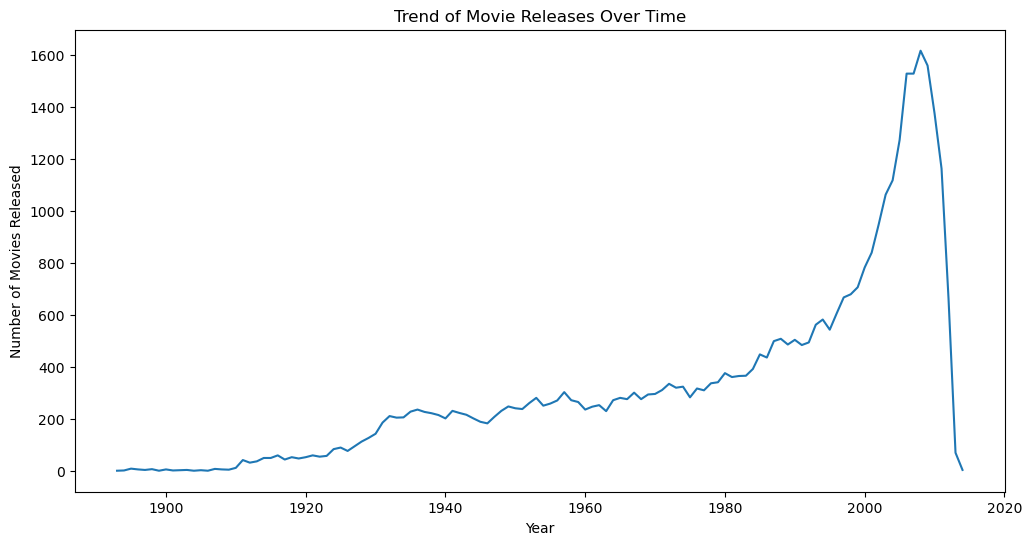

In [23]:
plt.figure(figsize=(12, 6))
movies_summary.groupby('Movie Release Year').size().plot(kind='line')
plt.title('Trend of Movie Releases Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.show()


### Distribution of Sentiment Scores

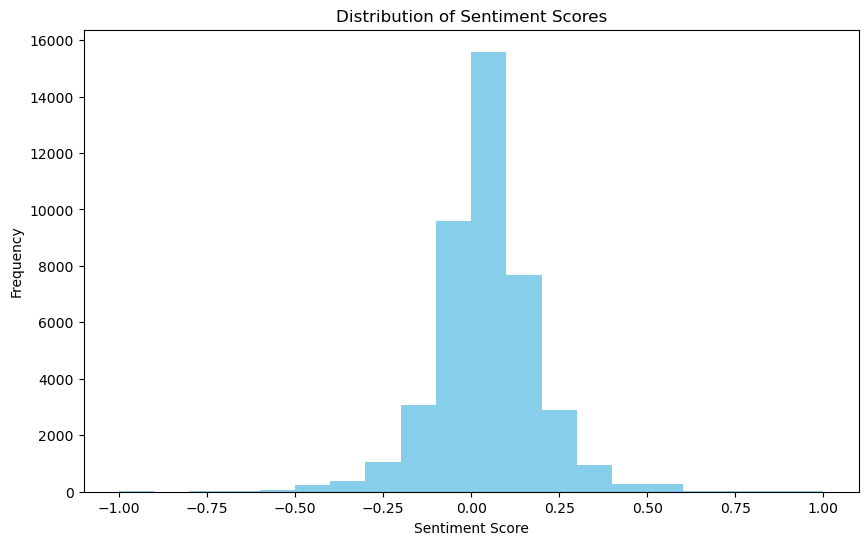

In [24]:
plt.figure(figsize=(10, 6))
movies_summary['Sentiment score plot'].plot(kind='hist', bins=20, color='skyblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


## Generations

In [22]:
# Create generations with name, start year and end year (considering oldest movie in dataset)

generations_dict = {
    "Generation": ["Lost Generation", "Greatest Generation", "Silent Generation", "Baby Boomers", 
                   "Generation X", "Millennials", "Generation Z", "Generation Alpha"],
    "Start Year": [1883, 1901, 1928, 1946, 1965, 1981, 1997, 2010],
    "End Year": [1900, 1927, 1945, 1964, 1980, 1996, 2009, 2023]
}
generations = pd.DataFrame(generations_dict)

In [23]:
display(generations)

,Generation,Start Year,End Year
0,Lost Generation,1883,1900
1,Greatest Generation,1901,1927
2,Silent Generation,1928,1945
3,Baby Boomers,1946,1964
4,Generation X,1965,1980
5,Millennials,1981,1996
6,Generation Z,1997,2009
7,Generation Alpha,2010,2023


<font color="green">
 
The social norms and values of each generation are shaped by historical events, cultural developments, technological advances, and other societal changes.

### Lost Generation (born approximately 1883–1900)
- This generation came of age during World War I and the Roaring Twenties.
- They were often characterized by a sense of disillusionment with war.
- There was a notable shift toward modernist art and literature.

### Greatest Generation (born approximately 1901–1927)
- They lived through the Great Depression, which instilled values of frugality and a strong work ethic.
- Many served in World War II, leading to a strong sense of duty and sacrifice.
- They valued community cohesion and respect for authority.

### Silent Generation (born approximately 1928–1945)
- Grew up during economic depression and war but came of age during the post-war boom.
- They are often seen as conformist and civic-minded.
- A value for stability, hard work, and keeping quiet about one’s troubles was prevalent.

### Baby Boomers (born approximately 1946–1964)
- Came of age during the civil rights movement, Vietnam War, and the Sexual Revolution.
- They often challenged established social norms and authority.
- Values included individualism, equal rights, and personal freedom.

### Generation X (born approximately 1965–1980)
- Grew up during a time of economic uncertainty and the rise of divorce rates.
- Often values independence, resilience, and a balance between work and personal life.
- This generation is sometimes seen as skeptical and value-driven.

### Millennials (born approximately 1981–1996)
- Came of age during the internet boom, which influenced their values towards connectivity and innovation.
- They tend to value diversity, equality, and sustainability.
- Known for valuing experiences over material possessions.

### Generation Z (born approximately 1997–2009)
- They are digital natives who value inclusivity, individuality, and authenticity.
- Grew up during the global recession and are thus thought to be pragmatic and financially minded.
- Social justice and environmental concerns are significant for this group.

### Generation Alpha (born approximately 2010–2024)
- It's too early to fully define the norms and values of this generation.
- They are being raised in an era of advanced technology and artificial intelligence.
- Early indications suggest they will value digital literacy, mental health, and environmental issues.


In [24]:
# Function to determine the generation of a given year
def get_generation(year):
    for _, row in generations.iterrows():
        if row['Start Year'] <= year <= row['End Year']:
            return row['Generation']
    return "Unknown Generation"

In [25]:
movies_summary['Generation'] = movies_summary['Movie Release Year'].apply(get_generation)

In [26]:
display(movies_summary)

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary,Sentiment score plot,Generation
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001.0,Thriller,"[set, second, half, 22nd, century, film, depic...",-0.075099,Generation Z
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987.0,Thriller,"[series, murder, rich, young, woman, throughou...",0.039072,Millennials
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama],1983.0,Drama,"[eva, upper, class, housewife, becomes, frustr...",0.152296,Millennials
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",2002.0,Family Film,"[every, hundred, year, evil, morgana, return, ...",-0.036790,Generation Z
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1997.0,Romantic comedy,"[adam, san, francisco-based, artist, work, cab...",0.162716,Generation Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42199,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",1941.0,Crime Fiction,"[plot, film, open, great, western, express, sp...",-0.052381,Silent Generation
42200,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama],2011.0,Drama,"[two, former, national, oceanic, atmospheric, ...",0.095833,Generation Alpha
42201,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",2011.0,Biographical film,"[plot, film, follows, 12, year, life, 3, irish...",0.010000,Generation Alpha
42202,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",1992.0,Science Fiction,"[story, take, place, year, 2092, super, dimens...",0.185669,Millennials


### Number of Movies Released Per Generation

In [27]:
# Count the number of movies per generation
movies_per_generation = movies_summary['Generation'].value_counts()

# Display the result
print(movies_per_generation)

Generation
Generation Z           14298
Millennials             7636
Generation X            4978
Baby Boomers            4750
Silent Generation       3582
Generation Alpha        3272
Unknown Generation      2619
Greatest Generation     1033
Lost Generation           36
Name: count, dtype: int64


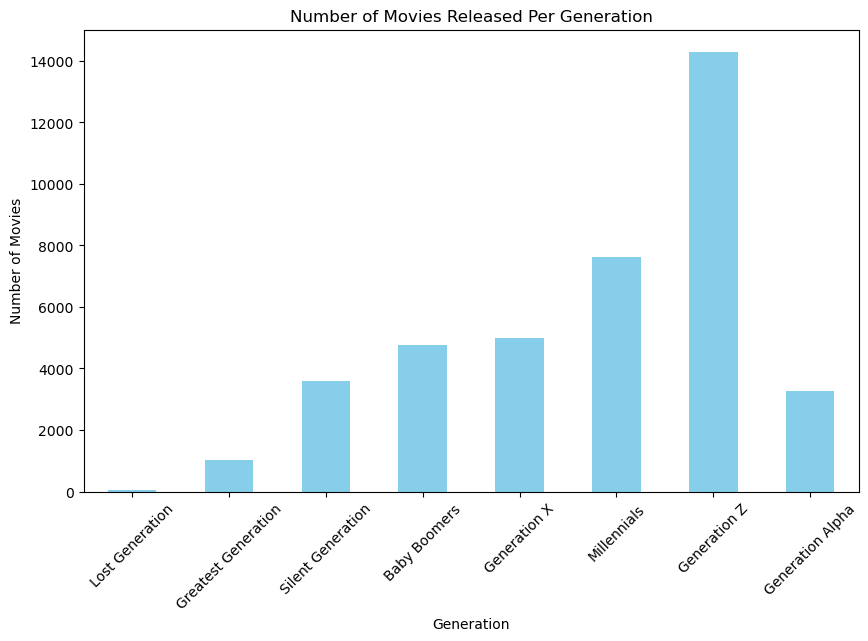

In [31]:
# Sort the count in the same order as the generations are defined
sorted_movies_per_generation = movies_per_generation.reindex(generations['Generation']).fillna(0)

# Plotting
plt.figure(figsize=(10,6))
sorted_movies_per_generation.plot(kind='bar', color='skyblue')
plt.title('Number of Movies Released Per Generation')
plt.xlabel('Generation')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

<font color="green">
    
A clear upward trend in movie production is visible from the Silent Generation to Generation Z, with a peak in the number of movies during the Generation Z. This could be attributed to advancements in technology, increased demand for entertainment content, and the growth of the film industry as a whole. Notably, there is a drop in movie releases for Generation Alpha, which suggest a shift in entertainment consumption patterns, such as the rise of streaming services and digital content over traditional movie releases.

### Sentiment Scores by Generation

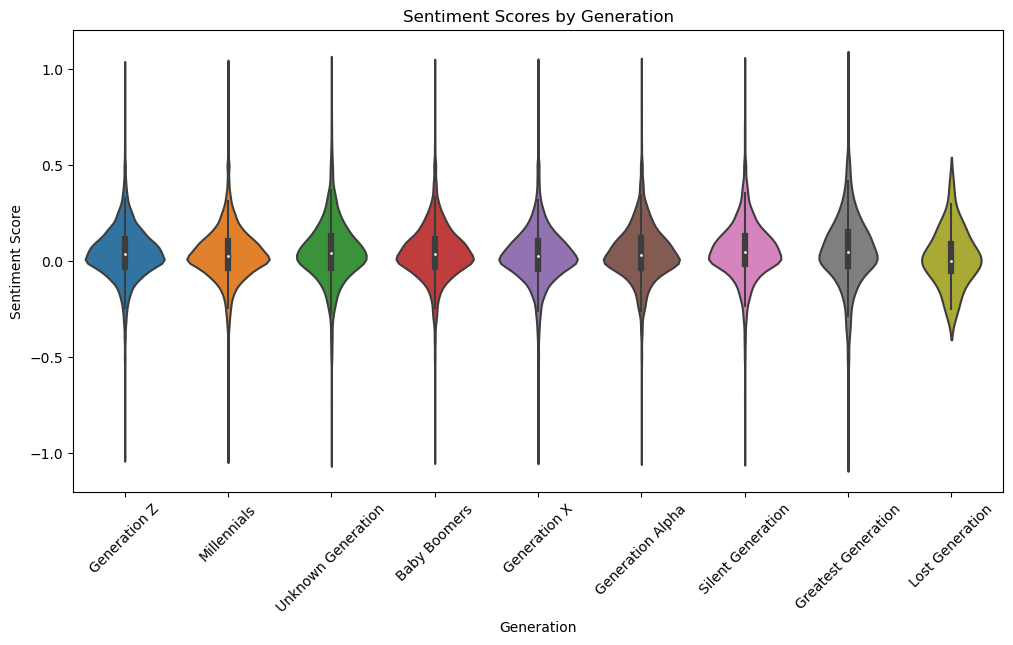

In [32]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Generation', y='Sentiment score plot', data=movies_summary)
plt.title('Sentiment Scores by Generation')
plt.xlabel('Generation')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()


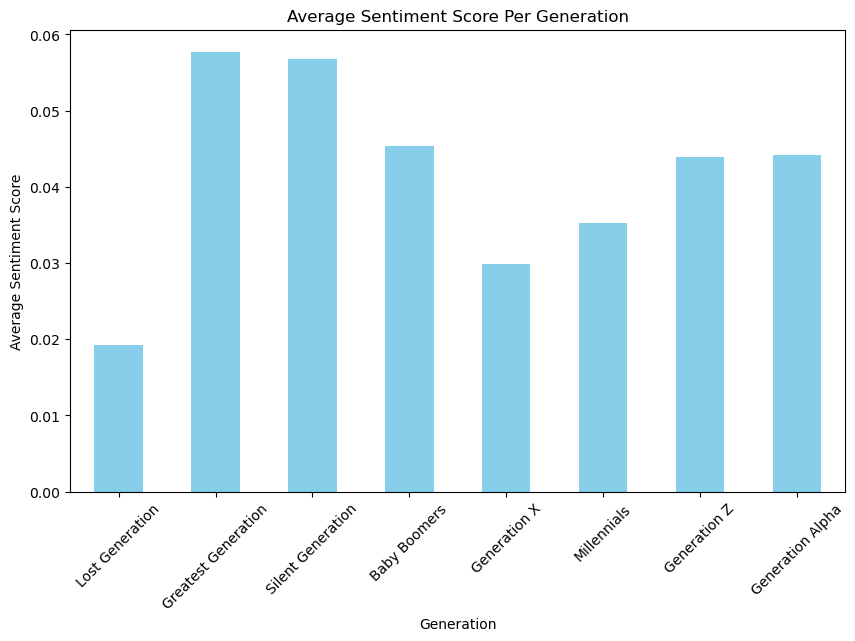

In [33]:
# Group by generation and calculate average sentiment score
avg_sentiment_per_generation = movies_summary.groupby('Generation')['Sentiment score plot'].mean()

# Sort the average sentiment score in the same order as the generations are defined
sorted_avg_sentiment_per_generation = avg_sentiment_per_generation.reindex(generations['Generation']).fillna(0)

# Plotting
plt.figure(figsize=(10,6))
sorted_avg_sentiment_per_generation.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score Per Generation')
plt.xlabel('Generation')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

<font color="green">

- **Greatest Generation**: Exhibiting the highest average sentiment score, this suggests that movies from or about this era (1901-1927) may be characterized by more positive themes or have been received more positively by audiences. This time, often remembered for the Roaring Twenties, might be depicted in films with a sense of nostalgia and positivity.

- **Lost Generation & Baby Boomers**: These generations show lower average sentiment scores, which could reflect the complex and tumultuous events during these times, such as World War I and the Vietnam War, respectively. Films from these periods or about these generations may thus have a more serious or contemplative tone.

- **Generation X, Millennials, & Generation Z**: The sentiment scores are quite consistent across these generations, which might indicate a stability in the emotional content of movies or a balance between different genres and themes from 1965 to 2009.

- **Generation Alpha**: Although this generation is still very young, the slightly higher sentiment score compared to Millennials and Generation Z could be due to the prevalence of family-friendly and animated films that generally carry positive sentiments.


## Genres and Generations

### Top 10 Movie Main Genres Distribution

In [28]:
# Identify the top 10 most prevalent genres
top_genres = movies_summary['Main Genre'].value_counts().head(10).index.tolist()

# Filter the DataFrame to include only the top genres
movies_top_genres = movies_summary[movies_summary['Main Genre'].isin(top_genres)]


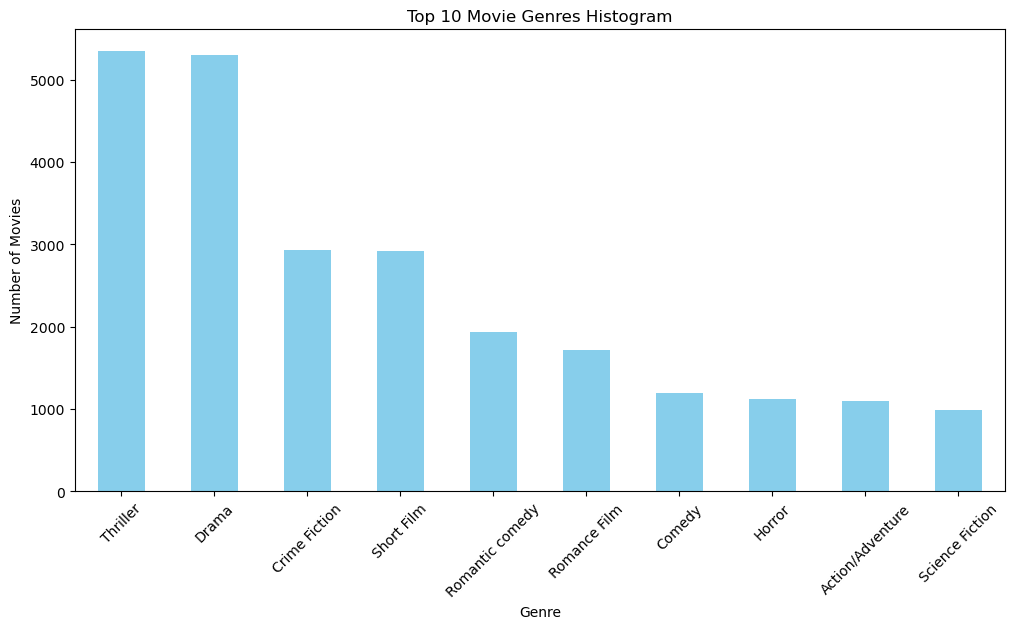

In [35]:
genre_counts = movies_summary['Main Genre'].value_counts().head(10)

# Plotting
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Movie Genres Histogram')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()


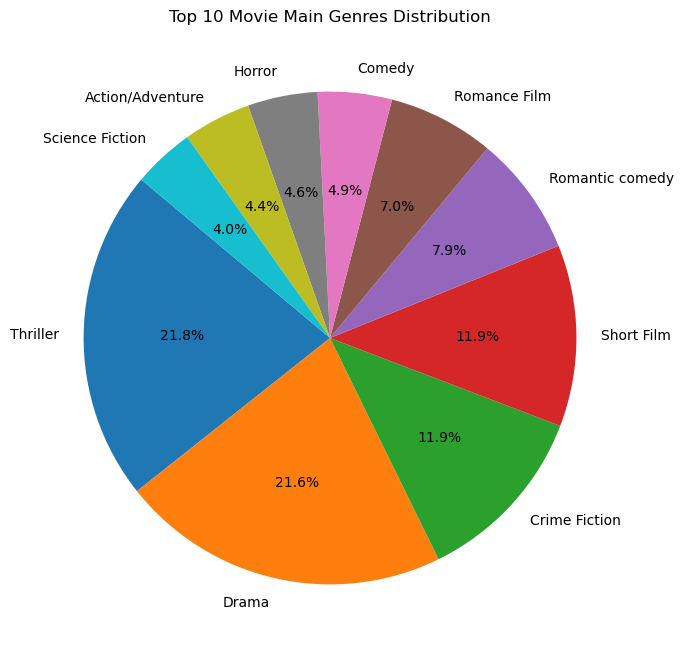

In [36]:
plt.figure(figsize=(12, 8))
movies_summary['Main Genre'].value_counts().head(10).plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Movie Main Genres Distribution')
plt.ylabel('') 
plt.show()


### Movie Genre Distribution Across Generations


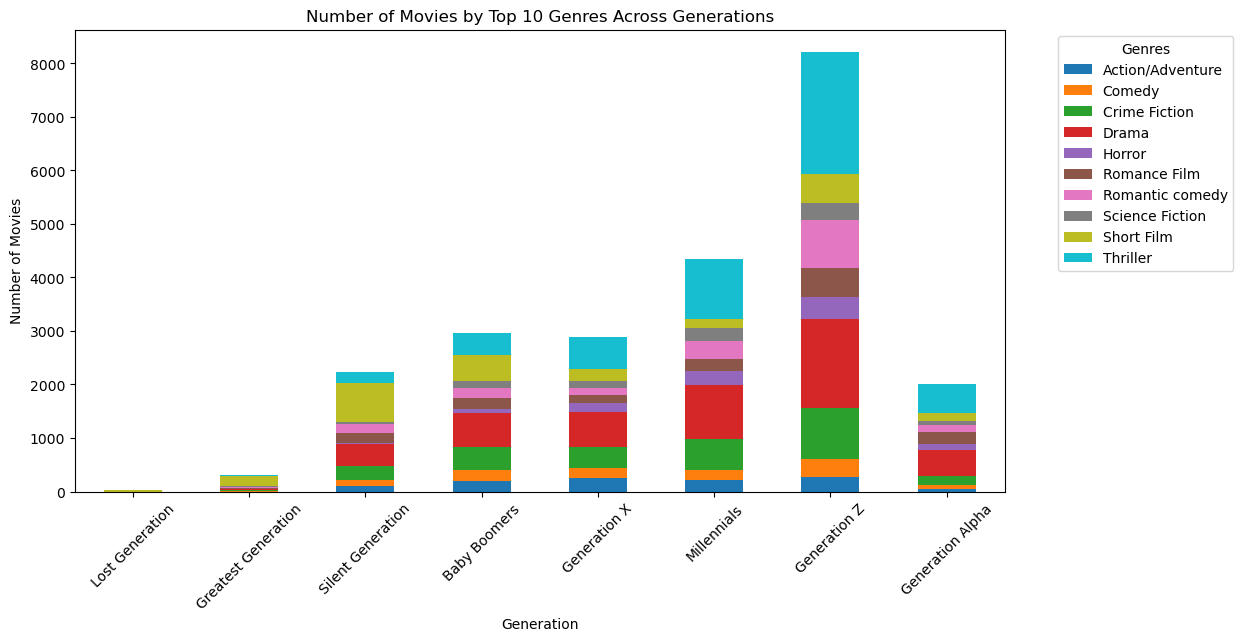

In [37]:
generations_order = generations['Generation'].tolist()  # This assumes 'generations' is in the correct order
movies_top_genres['Generation'] = pd.Categorical(movies_top_genres['Generation'], categories=generations_order, ordered=True)

# Count the occurrences of the top genres within each generation
genre_by_generation = pd.crosstab(movies_top_genres['Generation'], movies_top_genres['Main Genre'])

genre_by_generation = genre_by_generation.reindex(generations_order)

# Plotting a stacked bar chart
genre_by_generation.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of Movies by Top 10 Genres Across Generations')
plt.xlabel('Generation')
plt.ylabel('Number of Movies')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


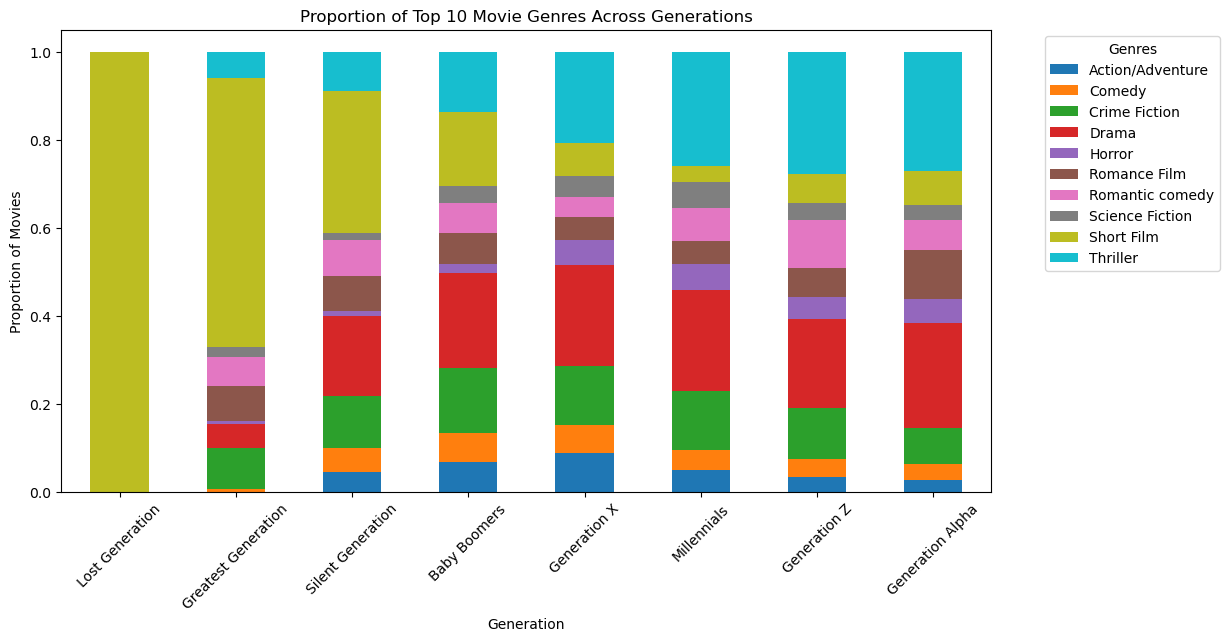

In [38]:
# Normalize the counts to get proportions
genre_by_generation_normalized = genre_by_generation.div(genre_by_generation.sum(axis=1), axis=0)

# Reindex the DataFrame to ensure it's in the order of the generations
genre_by_generation_normalized = genre_by_generation_normalized.reindex(generations_order)

# Plotting a normalized stacked bar chart
genre_by_generation_normalized.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Proportion of Top 10 Movie Genres Across Generations')
plt.xlabel('Generation')
plt.ylabel('Proportion of Movies')
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Ensures generation labels are rotated for better readability
plt.show()


<font color="green">

The plot above illustrates the distribution of the top 10 movie genres for each generation. This visualization highlights the shifting landscape of movie genre popularity from the early 20th century to the present day.

<font color="green">

Taking the Crime Fiction genre as an example, its notable and consistent presence across generations suggests a sustained interest in this genre's themes and storytelling. Similarly, the Drama genre has shown remarkable endurance, maintaining its popularity since the Silent Generation.

On the other hand, the Short Film genre has seen a decline over time, potentially reflecting a shift in the entertainment industry towards longer, more immersive narratives.

Conversely, the Thriller genre has seen an expansion in its share of movie production, suggesting an increasing appetite for suspense and excitement in cinematic experiences.

The fluctuations in these proportions are often reflective of broader societal dynamics, including historical events, technological breakthroughs that pave the way for new forms of cinematic expression, and shifts in social norms and values. These factors collectively shape the content produced by filmmakers and determine the genres that find resonance with audiences.

<font color="green">
    
The following observations were made:
    
- **Consistent Genres**: Comedy and Drama are consistently popular across all generations, reflecting their enduring appeal.

- **Technological Influence**: The rise in popularity of Science Fiction and Thriller in recent generations may be attributed to advancements in film-making technology.

- **Historical Trends**: Earlier generations such as the Lost and Greatest show a narrower genre focus, likely reflecting the historical limitations of the film industry.

- **Modern Diversification**: Later generations like Millennials, Generation Z, and Alpha exhibit a more balanced genre spread, suggesting a diversification of audience preferences and an industry response to a broader array of interests.


In [39]:
lost_generation_movies = movies_summary[movies_summary['Generation'] == 'Lost Generation']
lost_generation_movies

,Wikipedia Movie ID,Freebase Movie ID,Movie Name,Movie Release Date,Movie Box Office Revenue,Movie Runtime,Movie Languages,Movie Countries,Movie Genres,Movie Release Year,Main Genre,Plot Summary,Sentiment score plot,Generation
1788,9119884,/m/027ych_,As Seen Through a Telescope,1900-01-01,NaN,0.700000,"[Silent, English]",[United Kingdom],"[Short Film, Silent film, Indie, Black-and-white]",1900.0,Short Film,"[old, gentleman, shown, village, street, looki...",0.028698,Lost Generation
4269,11453521,/m/02rd7zz,The Ball Game,1898-05-20,NaN,NaN,[Silent],[United States of America],"[Short Film, Silent film, Indie, Documentary]",1898.0,Short Film,"[film, contains, footage, 1898, baseball, game...",-0.266667,Lost Generation
4568,10309988,/m/02q82wf,The Photographical Congress Arrives in Lyon,1895-06-12,NaN,NaN,[Silent],[France],"[Short Film, Silent film, Indie, Black-and-whi...",1895.0,Short Film,"[photographer, leave, deck, riverboat, large, ...",0.214286,Lost Generation
5785,32079836,/m/0gwycxv,On the Roof,1897-01-01,NaN,1.183333,[Silent],[France],"[Short Film, Silent film]",1897.0,Short Film,"[woman, call, help, window, two, burglar, clim...",-0.200000,Lost Generation
8036,34573948,/m/0j28m6r,Playing Cards,1896-01-01,NaN,1.000000,[Silent],[France],"[Short Film, Biographical film]",1896.0,Short Film,"[three, men, sitting, table, two, playing, car...",0.133333,Lost Generation
9648,11696927,/m/02rpb5v,Bataille de boules de neige,1896-01-01,NaN,NaN,[Silent],[France],"[Short Film, Silent film, Indie, Black-and-whi...",1896.0,Short Film,"[dozen, people, men, woman, seen, snowball, fi...",0.000000,Lost Generation
10947,2654820,/m/07vq4_,The Nearsighted School Teacher,1898-07-01,NaN,NaN,[],[United States of America],"[Short Film, Silent film, Comedy]",1898.0,Short Film,"[case, schoolmaster, come, grief, seated, desk...",-0.100000,Lost Generation
13274,73372,/m/0jq3g,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]",1893.0,Short Film,"[scene, filmed, stationary, camera, screen, la...",-0.037143,Lost Generation
14782,9419760,/m/02883bf,L'Arroseur Arrosé,1895-01-01,NaN,0.816667,[Silent],[France],"[Short Film, Silent film, Indie, Comedy]",1895.0,Short Film,"[shot, lyon, spring, 1895, film, portrays, sim...",-0.085714,Lost Generation
15630,10375919,/m/02q9tx2,The Derby,1895-01-01,NaN,0.466667,[Silent],[United Kingdom],"[Short Film, Silent film, Indie, Documentary]",1895.0,Short Film,"[stationary, camera, look, diagonally, across,...",0.050000,Lost Generation


<font color="green">

The data reveals that short films were the dominant genre during the Lost Generation era. Additionally, we observe an interesting distribution of Movie Languages.

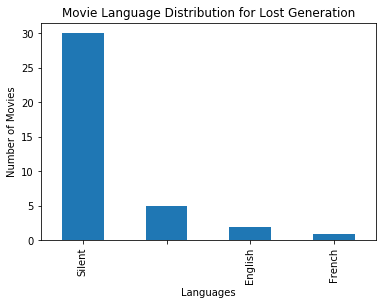

In [40]:
languages_series = lost_generation_movies['Movie Languages'].explode()

# Count the occurrences of each language
language_counts = languages_series.value_counts()

# Plot the histogram
language_counts.plot(kind='bar')
plt.title('Movie Language Distribution for Lost Generation')
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)  # Rotate the x labels to show them more clearly
plt.show()

<font color="green">
The bar chart depicts the distribution of languages in movies attributed to the 'Lost Generation'. The 'Silent' category is the most represented, which aligns with the historical context of the Lost Generation, where silent films were predominant before the advent of sound in movies. 

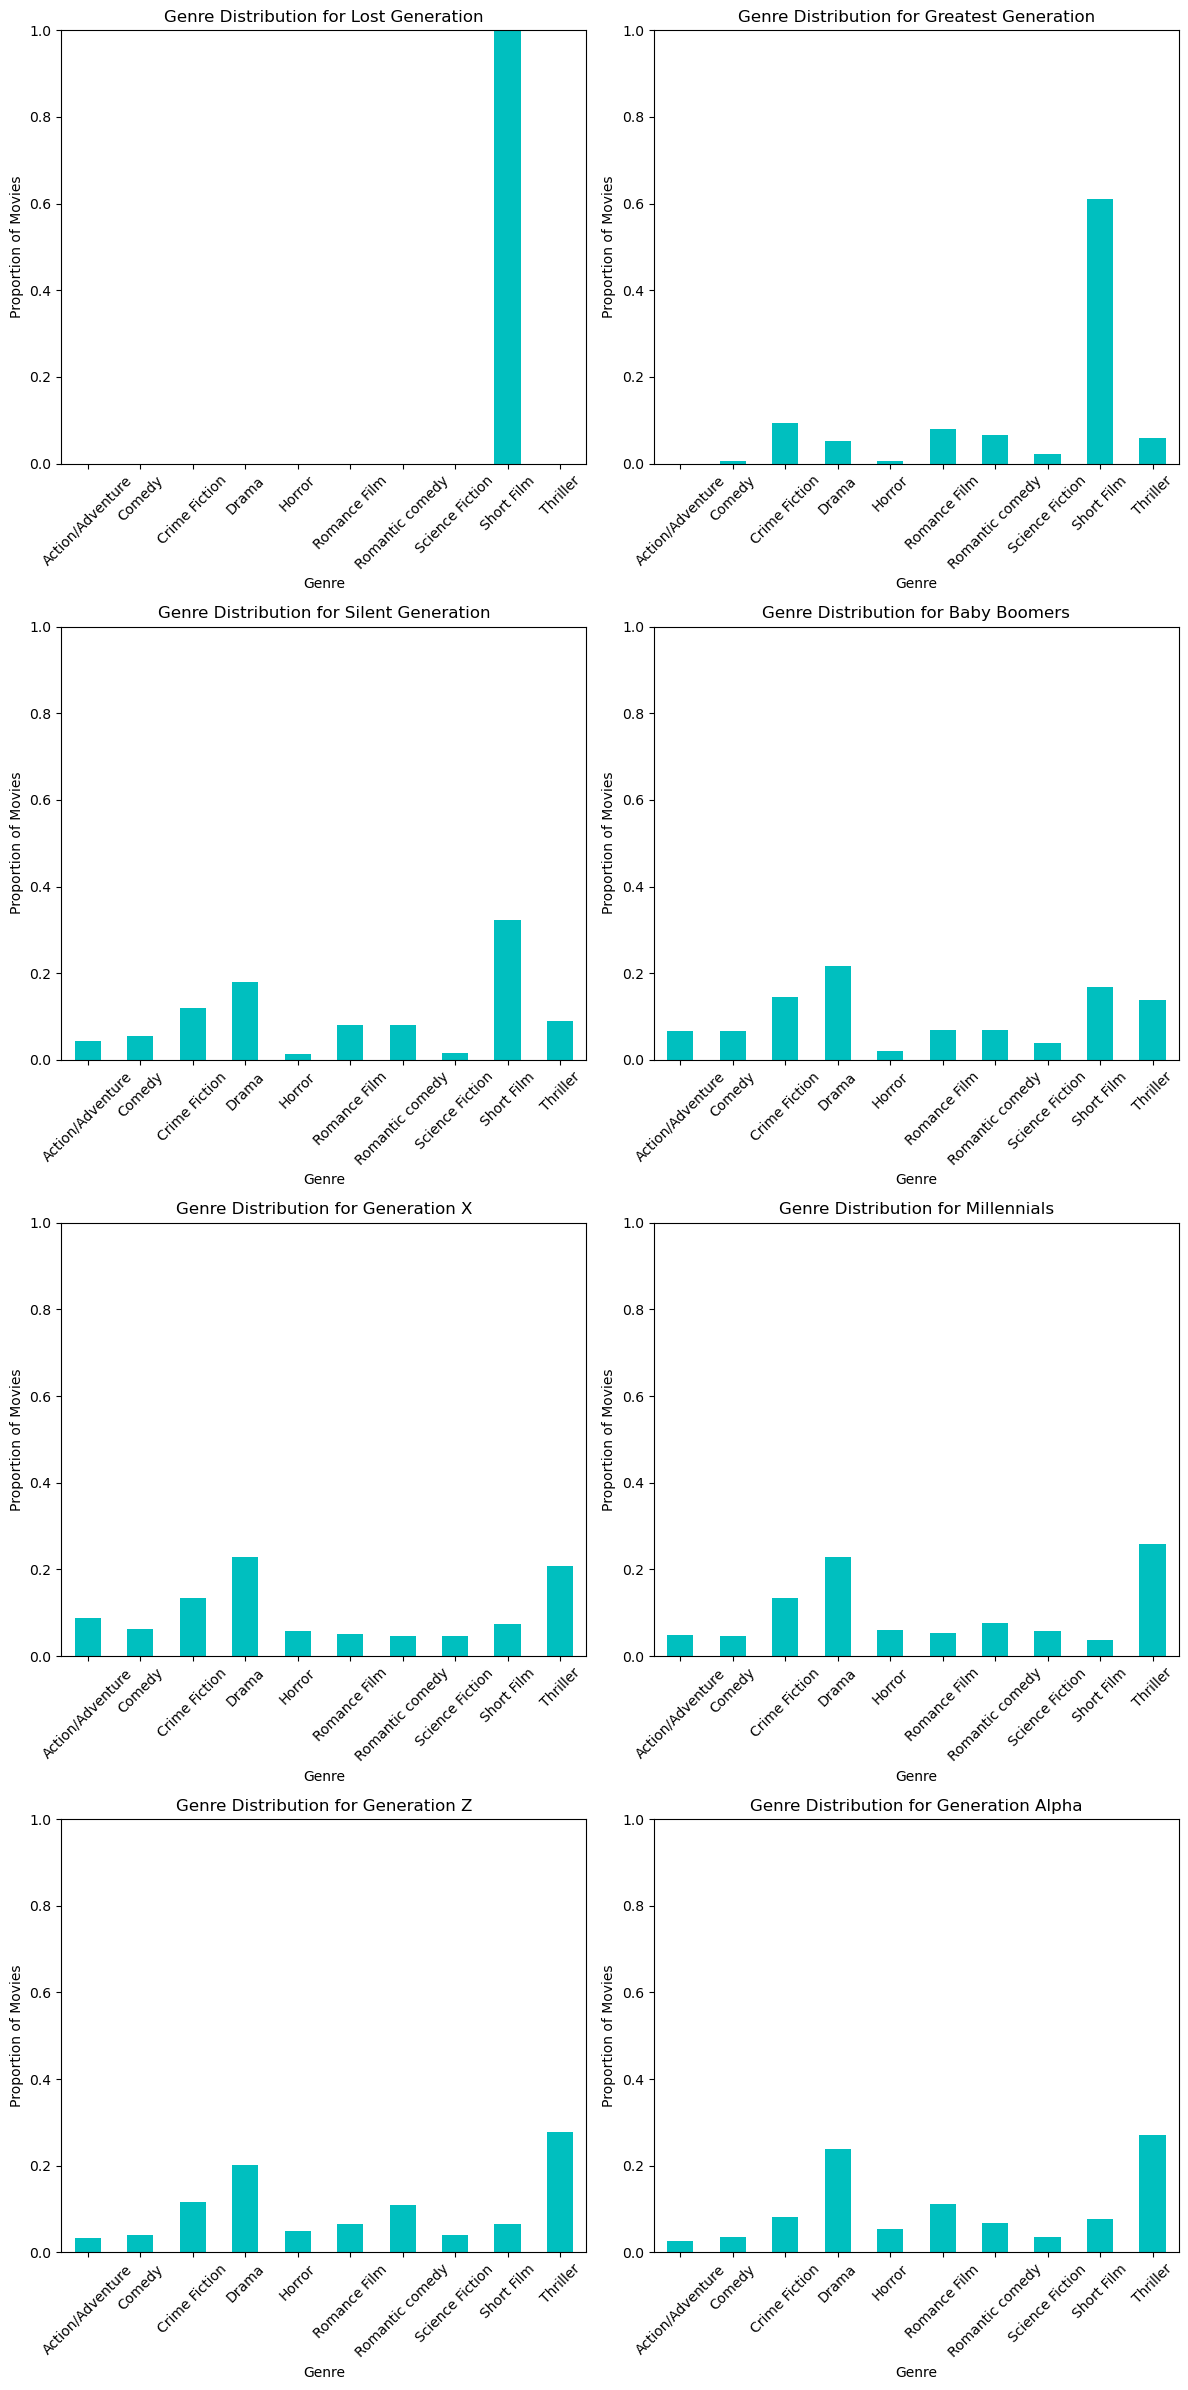

In [41]:
# Layout of the grid
num_generations = len(generations_order)
num_cols = 2  # You can adjust the number of columns based on your preference
num_rows = math.ceil(num_generations / num_cols)

# Subplots in a grid
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows))
axes = axes.flatten()

for i, gen in enumerate(generations_order):
    if gen in genre_by_generation_normalized.index:
        genre_by_generation_normalized.loc[gen].plot(kind='bar', ax=axes[i], color='c', title=f'Genre Distribution for {gen}')
        axes[i].set_xlabel('Genre')
        axes[i].set_ylabel('Proportion of Movies')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_ylim((0,1))
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()


<font color="green">
    
    
_____________
    
## Lost Generation
    
It's noteworthy that the Lost Generation is represented solely by the Short Film genre in the dataset. However, as we have seen above, this doesn't imply that only short films were produced during that time.

_____________
    
## Greatest Generation
    
The noticeable peak in the Short Film genre for the Greatest Generation suggests a strong preference for concise storytelling, which may have been due to the economic and practical constraints of the time, such as limited resources post-World War II and the necessity for cost-effective entertainment. Short films were likely more feasible to produce and provided a brief respite from the challenging realities of the era. The presence of other genres, while lower, indicates a diverse range of interests, but it's the Short Film genre that dominates, reflecting both the social norms of efficient, accessible entertainment and the value placed on the innovative storytelling that could be accomplished within a shorter format.
_____________     
## Silent Generation
    
In the provided chart, Short Films notably dominate the genre distribution for the Silent Generation, indicating a significant preference for this type of content during that period. This could be reflective of the Silent Generation's circumstances, where entertainment often had to be cost-effective and fit within the time constraints of audiences.

While Short Films clearly stand out, other genres such as Drama and Romance Films have a presence, though to a lesser degree. This suggests that, despite the brevity preferred in films of that era, there was still a demand for narrative storytelling that explored emotional and dramatic themes. The presence of these genres points to a balance between the desire for quick entertainment and the appreciation of more in-depth storytelling.

Comedy, Action/Adventure, and Horror genres appear even less frequently, which may indicate that these genres were less suited to the short film format or that they simply weren't as popular or as easily produced during the time.

_____________
## Baby Boomers
    
The distribution of movie genres for the Baby Boomers generation shows a relatively even spread across several categories, with Drama standing out as the most prevalent. This may reflect the Baby Boomers' affinity for rich, narrative storytelling that mirrors the complex social issues of their time, such as civil rights movements and political upheaval.

Genres like Romance Film and Thriller also make noticeable appearances, indicating a taste for both emotional storytelling and suspenseful, edge-of-your-seat entertainment. The presence of these genres might align with the Baby Boomers' experiences during times of both cultural change and prosperity, as they sought various forms of escapism and connection through cinema.
_____________

## Millenials
    
In the genre distribution chart for Millennials, Drama and Thriller genres stand out, suggesting that Millennials gravitate towards films with complex narratives and suspenseful elements. This preference could stem from the Millennial generation's exposure to a variety of global and social issues like global terrorism, economic instability, social equality, climate change, digital privacy, and mental health. This observation aligns with their known values of diversity and social justice, which are often explored in depth within these genres.
_____________
## Generation Z

In Generation Z's movie genres distribution, Drama and Thriller stand out, mirroring the influence of key historical events. The strong representation of Drama aligns with Generation Z's involvement in social movements like climate activism and gun control. The prominence of Thrillers suggests a response to the uncertainty and challenges faced by this generation, possibly influenced by events like the Great Recession, capturing their inclination towards narratives that explore societal and personal complexities. 
_____________
## Generation Alpha

    
In Generation Alpha's movie genres distribution, Drama and Thriller stand out, mirroring the influence of key historical events. The prevalence of Drama reflects a heightened awareness of real-world issues like Black Lives Matter. Thrillers appeal to them, possibly influenced by the unpredictability of events like the global crisis.
    
In Generation Alpha's movie genres distribution, Drama and Thriller also stand out. The interest in Drama could be tied to the global conversations around racial justice (Black Lives Matter), reflecting Generation Alpha's exposure to and engagement with social issues from an early age. The affinity for Thrillers may be influenced by the unpredictability of events like the global crisis, capturing the attention of a generation growing up in an era marked by rapid technological advancements and evolving global challenges. Generation Alpha's genre preferences suggest a continuation of the trend of seeking narratives that resonate with their evolving social consciousness.
    

_____________

### Average Movie Runtime Per Generation

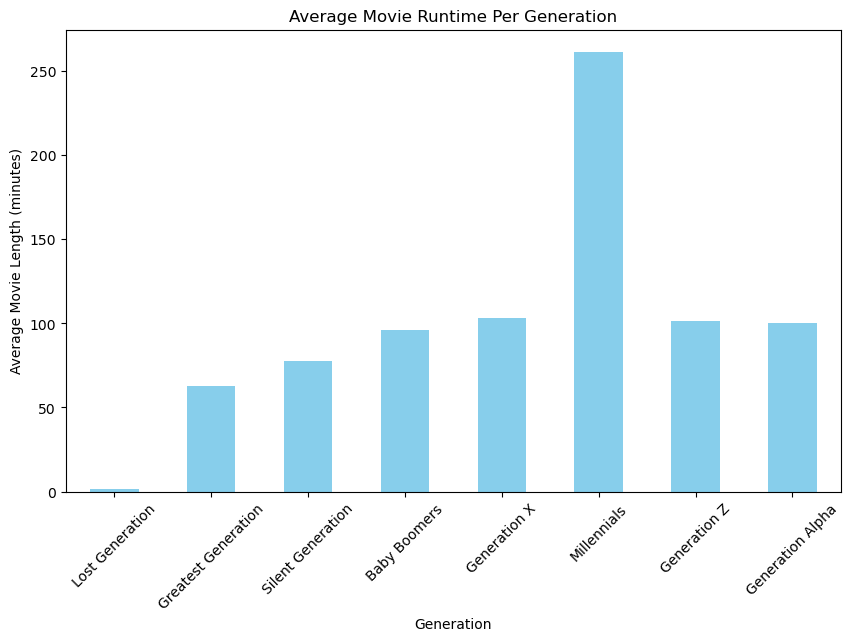

In [42]:
avg_length_per_generation = movies_summary.groupby('Generation')['Movie Runtime'].mean()
sorted_avg_length_per_generation = avg_length_per_generation.reindex(generations['Generation']).fillna(0)

plt.figure(figsize=(10, 6))
sorted_avg_length_per_generation.plot(kind='bar', color='skyblue')
plt.title('Average Movie Runtime Per Generation')
plt.xlabel('Generation')
plt.ylabel('Average Movie Length (minutes)')
plt.xticks(rotation=45)
plt.show()


<font color="green">

The bar chart above illustrates significant variability in average movie runtimes when viewed through the lens of generational change. This fluctuation can be attributed to several factors:

- **Technological Advancements**: As film technology evolved, it allowed for more complex storytelling. The advent of sound in movies, for example, during the transition from the Silent Generation to the Baby Boomers, likely contributed to longer runtimes as dialogue became an integral part of film narrative.

- **Economic Factors**: During economic booms, studios might have more budget to produce epic-scale movies with longer runtimes. Conversely, during downturns like the Great Depression (Greatest Generation), more concise films might have been favored to conserve resources and adapt to audiences' financial constraints.

- **Cultural Movements**: The rise of television and other forms of entertainment in the home may have influenced movie lengths. As attention spans adjusted to shorter television programming, this could have been reflected in movie runtimes, particularly noticeable in the shorter films of Generation X compared to the Millennials.

- **Artistic Trends**: The Millennials' peak in runtime could also correlate with the rise of blockbuster franchises and epic series, where more extended runtimes are often used to develop complex storylines and character arcs.

- **Social Change**: Important historical events, such as wars or social movements, could impact film length. For instance, during times of war, there might be a trend towards shorter, morale-boosting films. In contrast, periods of social change might inspire more in-depth explorations of themes, leading to longer films.


## Regression analysis

**Methodology:** The regression analysis aims to explore the relationship between the main genre and the emotions/sentiment of the movie. We utilize sentiment scores and the intensities of eight emotions as predictors, and construct an Ordinary Least Squares (OLS) model for each genre. For every genre, the data is divided into two groups: the control group for movies not in this genre, and the treated group for movies in this genre. To reduce the effect of confounding factors, we filter the data to balance the variables `Movie Country`, `Movie Languages`, `Generation`, and `Movie Runtime` between control and treated groups. Exact matching is performed on the categorical confounder variables, while similarity matching is applied to the continuous variable `Movie Runtime` using an OLS model to calculate a similarity metric. Row-wise normalization and column-wise standardization are applied to the independent variables, thus the slopes of the linear regression models can be directly compared and reflect the influence of emotions and sentiment on the probability that a movie belongs to a specific genre.

In [29]:
def standardize(df, features):
    for feature in features:
        df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
    return df

def get_control_treated_split(df, column):
    control = df.groupby(column).get_group(0).copy()
    treated = df.groupby(column).get_group(1).copy()
    return control, treated

def plot_control_treated_feature(df, column, value, dtype):
    data = df[["Wikipedia Movie ID", column, value]]\
           .pivot(index="Wikipedia Movie ID", columns=column, values=value)
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=data)
    plt.xlabel("")
    plt.ylabel(value)
    ticks, _ = plt.xticks()
    plt.xticks(ticks=ticks, labels=["control", "treated"])
    plt.title(f"{value} for {column.split('_')[1]} {dtype} matching")
    plt.show()

In [41]:
# load emotion intensity vector
emotion = pd.read_csv("../generated/MovieIDs_emotions.csv")
emotion.head()

,Movie ID,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,23890098,0.545,0.508,0.000,0.000,0.514,0.000,0.578,0.656
1,31186339,21.194,12.817,8.796,28.742,13.018,16.055,7.102,17.189
2,20663735,12.641,6.514,3.917,14.270,10.557,11.749,3.398,17.851
3,2231378,10.029,14.450,3.774,11.866,42.855,8.775,6.217,14.474
4,595909,6.694,7.516,2.769,7.930,8.273,8.365,2.320,15.985


In [43]:
# Normalize intensity scores by the sum for each movie
emotion.iloc[:, 1:] = emotion.iloc[:, 1:].div(emotion.iloc[:, 1:].sum(axis=1), axis=0)
emotion.head()

,Movie ID,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,23890098,0.194573,0.181364,0.000000,0.000000,0.183506,0.000000,0.206355,0.234202
1,31186339,0.169670,0.102607,0.070417,0.230096,0.104217,0.128529,0.056856,0.137608
2,20663735,0.156260,0.080522,0.048420,0.176397,0.130499,0.145234,0.042004,0.220663
3,2231378,0.089194,0.128513,0.033565,0.105532,0.381137,0.078042,0.055292,0.128726
4,595909,0.111843,0.125576,0.046264,0.132493,0.138224,0.139761,0.038762,0.267075


In [45]:
# merge movie metadata and emotion intensities
df_reg = movies_summary.merge(emotion, left_on="Wikipedia Movie ID", right_on="Movie ID", how="inner"
         ).drop(columns=["Freebase Movie ID", "Movie Name", "Movie Genres", "Movie Release Year", 
                         "Movie Release Date", "Movie Box Office Revenue", "Plot Summary", "Movie ID"])

# clean up rows with missing variables for matching
features = ['Movie Languages', 'Movie Countries']
df_reg[features] = df_reg[features].map(lambda x: x[0] if isinstance(x, list) and x[0] != '' else np.nan)
df_reg.dropna(how='any', axis=0, inplace=True)
df_reg = df_reg[df_reg["Generation"] != "Unknown Generation"]

# remove an apparent outlier in `Movie Runtime`
df_reg = df_reg[df_reg["Movie Runtime"] != 1079281.0]

# retain movies with main genre in the top-10 genres
df_reg = df_reg.loc[df_reg["Main Genre"].isin(top_genres)]
print(f"Number of movies used for matching: {len(df_reg)}")

Number of movies used for matching: 17974


In [46]:
# standardize continuous variable
contd_feats = ['Movie Runtime', 'Sentiment score plot', 'anger', 'anticipation',
               'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
df_reg = standardize(df_reg, contd_feats)

# get dummies for categorical variables
cat_feats = list(set(df_reg.columns) - set(contd_feats) - set(['Wikipedia Movie ID']))
df_reg = pd.get_dummies(df_reg, columns=cat_feats)

# handle a special case with utf-8 encoding
df_reg.rename(columns={"Movie Languages_M\\u0101ori": "Movie Languages_Maori"}, inplace=True)

# convert dummy encoding to 0 and 1
dummy_feats = [c for c in df_reg.columns if c.startswith(tuple([f"{c}_" for c in cat_feats]))]
df_reg[dummy_feats] = df_reg[dummy_feats].astype(int)

An exploration of the linear relationship between `Main Genre` and `Movie Runtime` revealed a moderate correlation for `Short Film` and a weak yet significant correlation for `Drama` and `Thriller`. These findings imply the necessity of applying similarity matching to the runtime variable for these two genres. A look into the distribution of runtime in `Drama` and `Thriller` after exact matching suggest a satisfying balance of runtime between the control and treated groups, thus eliminating the need of further matching on this variable for the two genres.

In [47]:
# examine the correlation between genre and runtime
genre_feats = [c for c in df_reg.columns if c.startswith("Main Genre_")]
rsquared = []

for genre in genre_feats:
    mod = smf.ols(formula=f'Q("{genre}") ~ Q("Movie Runtime")', data=df_reg).fit()
    key = genre.split('_')[1]
    rsquared.append({"genre": key, "R-square": mod.rsquared})
pd.DataFrame.from_dict(rsquared)

,genre,R-square
0,Action/Adventure,0.003268
1,Comedy,0.000027
2,Crime Fiction,0.002082
3,Drama,0.016830
4,Horror,0.000375
5,Romance Film,0.005892
6,Romantic comedy,0.002209
7,Science Fiction,0.000020
8,Short Film,0.339500
9,Thriller,0.012647


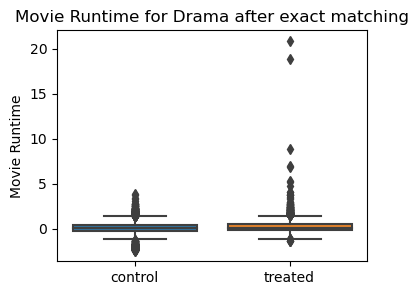

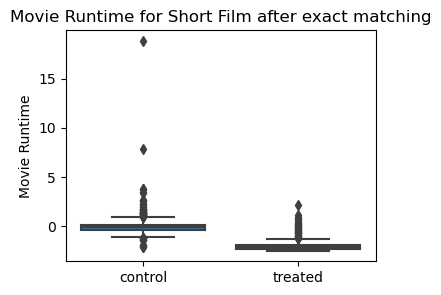

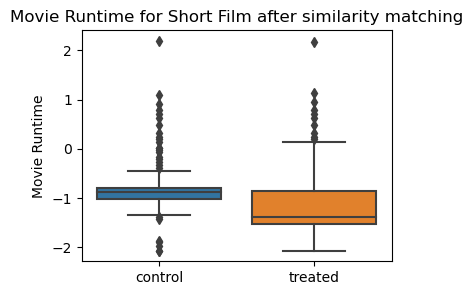

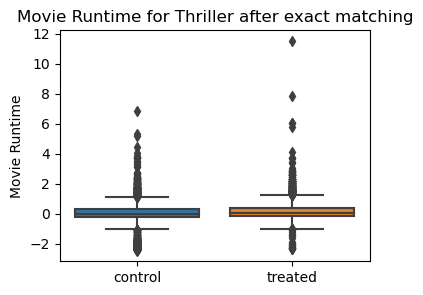

In [48]:
import networkx as nx

params, pvalues = {}, {}
models, stats = [], []

X_feats = ['Sentiment score plot', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
match_feats = [c for c in df_reg.columns if c.startswith(("Movie Languages_", "Movie Countries", "Generation_"))]

for genre in genre_feats:
    # perform exact one-to-one matching on categorical variables
    df_control, df_treated = get_control_treated_split(df_reg, genre)
    df_merged = df_control.merge(df_treated, on=match_feats)
    
    # get matched pairs of movie IDs
    pairs = [[i, j] for i, j in zip(df_merged["Wikipedia Movie ID_x"], df_merged["Wikipedia Movie ID_y"])]
    
    # ensure the matching is one-to-one
    filtering = set()
    matched_ids = []
    for pair in pairs:
        if pair[0] not in filtering and pair[1] not in filtering:
            matched_ids.extend(pair)
            filtering.add(pair[0])
            filtering.add(pair[1])
    
    # remove unmatched movies
    df_balanced = df_reg.loc[df_reg["Wikipedia Movie ID"].isin(matched_ids)]
    
    # plot runtime distribution before matching for `Thriller`
    if genre in ["Main Genre_Drama", "Main Genre_Thriller"]:
        plot_control_treated_feature(df_balanced, genre, "Movie Runtime", "after exact")
    
    # perform similarity matching on runtime
    if genre in ["Main Genre_Short Film"]:
        # plot runtime distribution before matching
        plot_control_treated_feature(df_balanced, genre, "Movie Runtime", "after exact")
        
        # split into control and treated groups
        df_control, df_treated = get_control_treated_split(df_balanced, genre)
        
        # calculate propensity score
        mod = smf.ols(formula=f'Q("{genre}") ~ Q("Movie Runtime")', data=df_balanced).fit()
        scores = mod.predict(df_balanced["Movie Runtime"])
        
        # matching
        G = nx.Graph()
        for i in df_control.index:
            for j in df_treated.index:
                similarity = 1 - np.abs(scores.loc[i] - scores.loc[j])
                if similarity >= 0.8:
                    G.add_weighted_edges_from([(i, j, similarity)])
        matching = nx.max_weight_matching(G)
        
        # remove unmatched movies
        control_id = [ids[0] for ids in matching]
        treated_id = [ids[1] for ids in matching]
        unmatched_id = set(df_balanced.index) - set(control_id) - set(treated_id)
        df_balanced.drop(unmatched_id, axis=0, inplace=True)
        
        # plot runtime distribution before matching
        plot_control_treated_feature(df_balanced, genre, "Movie Runtime", "after similarity")
    
    # regression
    mod = smf.ols(formula=f'Q("{genre}")~' + "+".join([f'Q("{feat}")' for feat in X_feats]), data=df_reg).fit()
    
    # store statistics
    key = genre.split('_')[1]
    params[key] = mod.params.iloc[1:]
    pvalues[key] = mod.pvalues.iloc[1:]
    models.append(mod)
    stats.append({"genre": key, "R-square": mod.rsquared, "num. movies": len(df_balanced)})

In [49]:
pd.DataFrame(stats)

,genre,R-square,num. movies
0,Action/Adventure,0.026822,1840
1,Comedy,0.015588,1634
2,Crime Fiction,0.033122,4570
3,Drama,0.042665,6178
4,Horror,0.028228,1540
5,Romance Film,0.036343,1752
6,Romantic comedy,0.103592,3458
7,Science Fiction,0.013652,1582
8,Short Film,0.017213,208
9,Thriller,0.082365,8598


In [50]:
index = ["sentiment score" if x=="Sentiment score plot" else x for x in X_feats]
df_params = pd.DataFrame.from_dict(params)
df_params.index = index
df_pvalues = pd.DataFrame.from_dict(pvalues)
df_pvalues.index = index

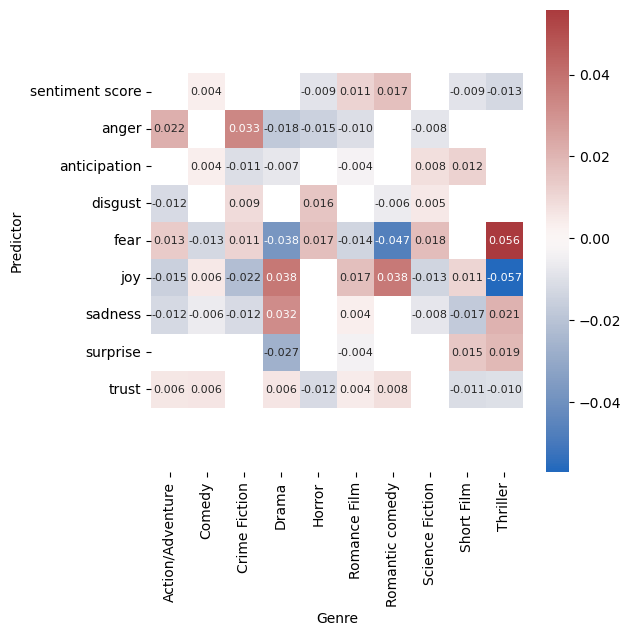

In [51]:
# Plot heatmap only for coefficients with p-value < 0.05
df_params_filt = df_params.copy()
mask = df_pvalues < 0.05
df_params_filt = df_params_filt[mask]
df_params_filt.to_csv("regression_params.csv")

plt.figure(figsize=(6, 6))
ax = sns.heatmap(df_params_filt, annot=True, center=0., cmap="vlag", fmt='.3f', annot_kws={"fontsize":8})
ax.set(xlabel="Genre", ylabel="Predictor")
plt.axis('equal')
plt.show()

<font color="green">

The heatmap displays the slopes of linear regressions between one-hot encoded genres and emotion intensities and sentiment score of movie plot summaries. All visualized slopes are statistically significant ($p$&lt;0.05). The slopes indicate the degree that an emotion or sentiment helps shape the genre, in other words, its effect on the likelihood that a movie belongs to a genre.
    
*   **Prevalence of Fear and Joy:** The emotions `fear` and `joy` emerge as the most relevant for most genres, indicated by significant regression slopes and relatively large slope magnitudes.

*   **Tension in Thriller:** The `Thriller` genre show the strongest association with emotions. Notably, `fear` and `joy` exhibit a positive and negative correlations with the probability of this genre, respectively, suggesting a generally negative emotional tone. This observation aligns with the genre's weakly negative relationship with the sentiment score. 
    
*   **Light Mood in Romantic Comedy** In contrast, the `Romantic Comedy` genre shows opposite trends in its relationship with `fear`, `joy`, and sentiment score compared to `Thriller`. These trends indicate a light mood within the genre.
    
*   **Diverse Emotions in Drama:** The genre `Drama` is characterized by positive correlations with `joy` and `sadness` and negative correlations with `fear`, `anger` and `surprise`, respectively, indicating a diverse range of emotions in this genre.

</font>